In [4]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
import matplotlib.pyplot as plt

# Can be None, "oversampling", "undersampling" or "weighted_loss" 
imbalance_strategy = None

In [5]:
# Import datasets
df_a = pd.read_parquet('../../data/tsfresh-set-a.parquet')
df_c = pd.read_parquet('../../data/tsfresh-set-c.parquet')

# Get labels
y_train = pd.read_csv('../../data/Outcomes-a.txt').sort_values(by=['RecordID']).set_index('RecordID')['In-hospital_death']
y_test = pd.read_csv('../../data/Outcomes-c.txt').sort_values(by=['RecordID']).set_index('RecordID')['In-hospital_death']

impute(df_a)
impute(df_c)

X_train = select_features(df_a, y_train)
X_test = df_c[X_train.columns]

if imbalance_strategy == "oversampling":
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

if imbalance_strategy == "undersampling":
    cc = ClusterCentroids(random_state=42)
    X_train, y_train = cc.fit_resample(X_train, y_train)


Random Forest Results:
  - AuROC: 0.8230
  - AuPRC: 0.4733


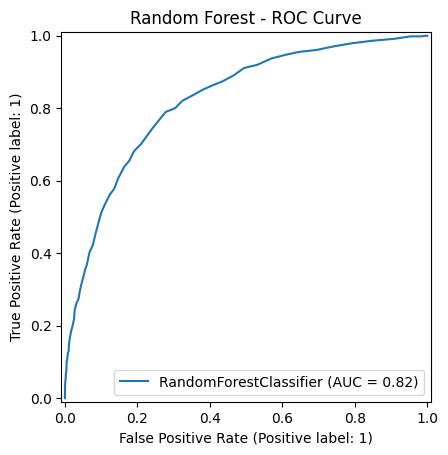

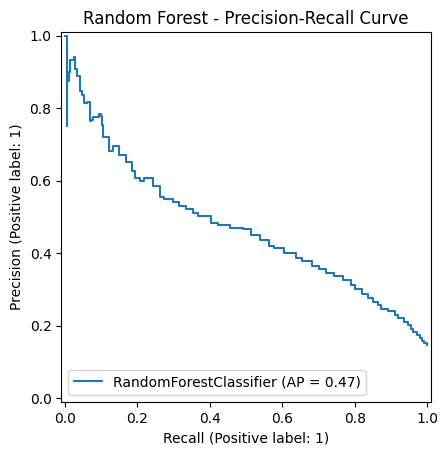

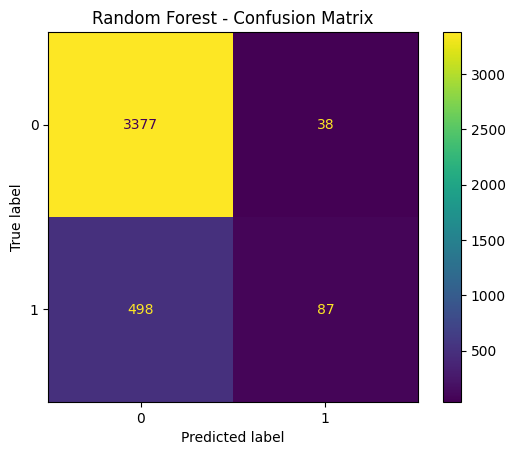


Logistic Regression Results:
  - AuROC: 0.4353
  - AuPRC: 0.1305


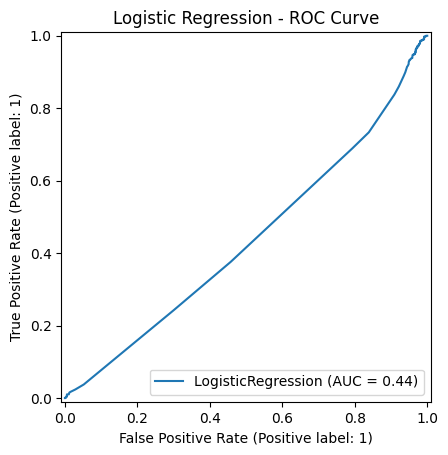

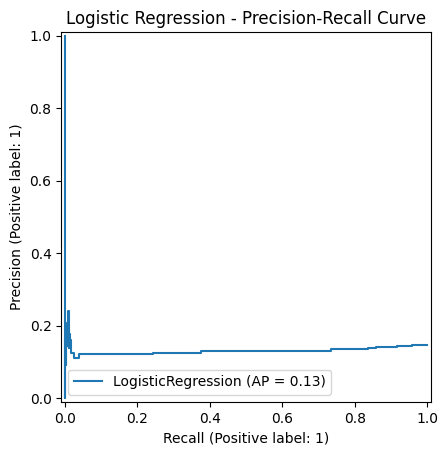

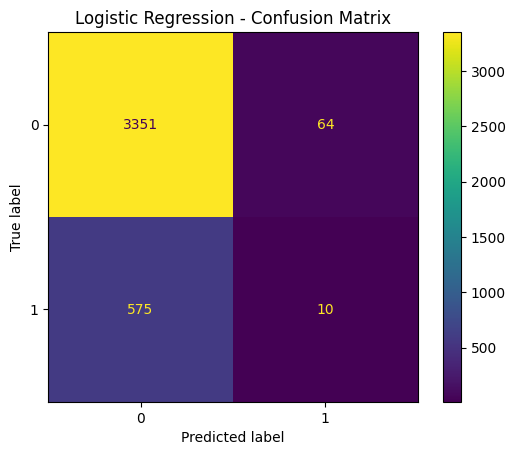

In [6]:
classifiers = {
    "Random Forest": RandomForestClassifier(
        random_state=42, 
        class_weight="balanced" if imbalance_strategy == "weighted_loss" else None
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight="balanced" if imbalance_strategy == "weighted_loss" else None
    )
}


for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)

    print(f"\n{name} Results:")
    print(f"  - AuROC: {auroc:.4f}")
    print(f"  - AuPRC: {auprc:.4f}")

    # Plot ROC Curve
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f'{name} - ROC Curve')
    plt.show()

    # Plot Precision-Recall Curve
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f'{name} - Precision-Recall Curve')
    plt.show()

    # Plot Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()